In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import json


In [2]:
# Dataset directory
dataset_dir = "garbage_dataset"

# Data generator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training data
train_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data
val_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("✅ Classes found:", train_data.class_indices)

# Save class indices for later use
with open("class_indices.json", "w") as f:
    json.dump(train_data.class_indices, f)


Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.
✅ Classes found: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [3]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    # 🚨 OPTIMIZATION: Reduced from 128 to 64 units to save memory
    Dense(64, activation='relu'), 
    Dense(train_data.num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 2340618 (8.93 MB)
Trainable params: 8263

In [4]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10


495/495 [==============================] - 585s 1s/step - loss: 1.1325 - accuracy: 0.6446 - val_loss: 0.5804 - val_accuracy: 0.8151
Epoch 2/10
495/495 [==============================] - 217s 438ms/step - loss: 0.5420 - accuracy: 0.8271 - val_loss: 0.4469 - val_accuracy: 0.8574
Epoch 3/10
495/495 [==============================] - 214s 433ms/step - loss: 0.4479 - accuracy: 0.8588 - val_loss: 0.3851 - val_accuracy: 0.8769
Epoch 4/10
495/495 [==============================] - 212s 428ms/step - loss: 0.4031 - accuracy: 0.8671 - val_loss: 0.3592 - val_accuracy: 0.8850
Epoch 5/10
495/495 [==============================] - 195s 395ms/step - loss: 0.3682 - accuracy: 0.8816 - val_loss: 0.3497 - val_accuracy: 0.8828
Epoch 6/10
495/495 [==============================] - 165s 333ms/step - loss: 0.3470 - accuracy: 0.8847 - val_loss: 0.3458 - val_accuracy: 0.8845
Epoch 7/10
495/495 [==============================] - 166s 336ms/step - loss: 0.3336 - accuracy: 0.8903 - val_loss: 0.3254 - 

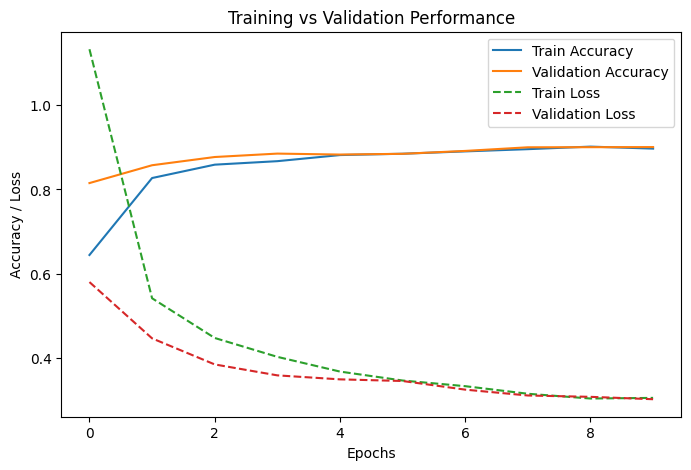

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Training vs Validation Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.legend()
plt.show()


In [6]:

model.save("waste_classifier_model_optimized.h5")
print("✅ Model saved successfully as waste_classifier_model_optimized.h5")

✅ Model saved successfully as waste_classifier_model_optimized.h5


C:\Users\manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import numpy as np
import json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 1️⃣ Load the saved model
model = load_model("waste_classifier_model_optimized.h5")

# 2️⃣ Load saved class labels
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
class_labels = list(class_indices.keys())

# 3️⃣ Path to test image (use your correct path)
# 🚨 FIX THIS LINE: You must provide the correct, absolute path 
# to where this file is CURRENTLY located on your local machine.
img_path = r"C:\Users\manis\Desktop\Study\Waste\plastic_3.jpg" # <--- THIS PATH IS NOT FOUND

# You must manually correct the path to the correct location on your PC.
# Example: If you moved it to your Desktop, the path will be different.

# 4️⃣ Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224)) 
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 5️⃣ Predict
predictions = model.predict(img_array)
pred_class = np.argmax(predictions)

print("🟢 Predicted Class:", class_labels[pred_class])

1/1 [==============================] - 1s 574ms/step
🟢 Predicted Class: plastic
